Import Libraries

In [403]:
import pandas as pd 
import numpy as np
import datetime  # to work with date as objects
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import SimpleRNN
from keras.layers import Dropout

Read the dataset

In [404]:
data_train = pd.read_csv('C://Users//Martins//Desktop//Dataset//Google_Stock_Price_Train.csv', index_col="Date", parse_dates=True)
data_test = pd.read_csv('C://Users//Martins//Desktop//Dataset//Google_Stock_Price_Test.csv')
data_train.head()

,Open,High,Low,Close,Volume
Date,,,,,
2012-01-03,325.25,332.83,324.97,663.59,"7,380,500"
2012-01-04,331.27,333.87,329.08,666.45,"5,749,400"
2012-01-05,329.83,330.75,326.89,657.21,"6,590,300"
2012-01-06,328.34,328.77,323.68,648.24,"5,405,900"
2012-01-09,322.04,322.29,309.46,620.76,"11,688,800"


In [405]:
data_train.shape

(1258, 5)

In [406]:
data_train.isnull().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [407]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2012-01-03 to 2016-12-30
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1258 non-null   float64
 1   High    1258 non-null   float64
 2   Low     1258 non-null   float64
 3   Close   1258 non-null   object 
 4   Volume  1258 non-null   object 
dtypes: float64(3), object(2)
memory usage: 59.0+ KB


In [408]:
# converting object dtypes to float in train data
data_train["Close"] = data_train["Close"].str.replace(",","").astype(float)
data_train["Volume"] = data_train["Volume"].str.replace(",","").astype(float)
data_train.dtypes

Open      float64
High      float64
Low       float64
Close     float64
Volume    float64
dtype: object

In [409]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    20 non-null     object 
 1   Open    20 non-null     float64
 2   High    20 non-null     float64
 3   Low     20 non-null     float64
 4   Close   20 non-null     float64
 5   Volume  20 non-null     object 
dtypes: float64(4), object(2)
memory usage: 1.1+ KB


In [410]:
# converting object dtypes to float in test data
data_test["Volume"] = data_test["Volume"].str.replace(",","").astype(float)
data_test.dtypes

Date       object
Open      float64
High      float64
Low       float64
Close     float64
Volume    float64
dtype: object

In [411]:
data_train.describe()

,Open,High,Low,Close,Volume
count,1258.000000,1258.000000,1258.000000,1258.000000,1.258000e+03
mean,533.709833,537.880223,529.007409,712.669666,3.158107e+06
std,151.904442,153.008811,150.552807,164.752591,2.273726e+06
min,279.120000,281.210000,277.220000,491.200000,7.900000e+03
25%,404.115000,406.765000,401.765000,576.740000,1.621700e+06
50%,537.470000,540.750000,532.990000,695.675000,2.566150e+06
75%,654.922500,662.587500,644.800000,782.105000,4.122500e+06
max,816.680000,816.680000,805.140000,1216.830000,2.497790e+07


In [412]:
data_train.head()

,Open,High,Low,Close,Volume
Date,,,,,
2012-01-03,325.25,332.83,324.97,663.59,7380500.0
2012-01-04,331.27,333.87,329.08,666.45,5749400.0
2012-01-05,329.83,330.75,326.89,657.21,6590300.0
2012-01-06,328.34,328.77,323.68,648.24,5405900.0
2012-01-09,322.04,322.29,309.46,620.76,11688800.0


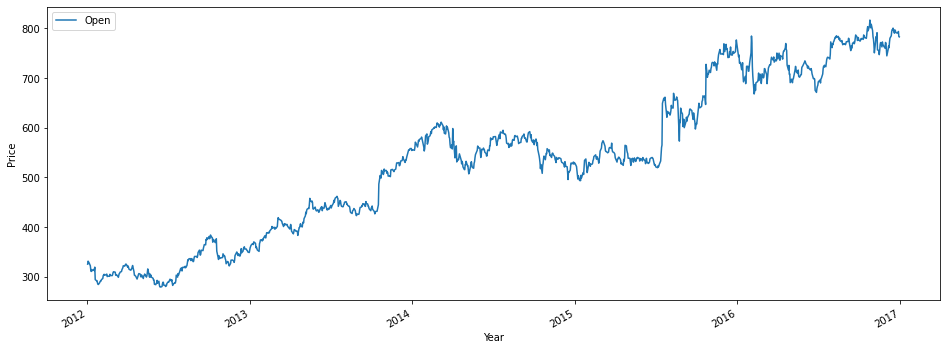

In [413]:
data_train["Open"].plot(figsize=(16,6))
plt.xlabel("Year")
plt.ylabel("Price")
plt.legend(loc="best")

In [414]:
# 7 days rolling mean on the training dataset

data_train.rolling(window=7).mean().head(10)

,Open,High,Low,Close,Volume
Date,,,,,
2012-01-03,NaN,NaN,NaN,NaN,NaN
2012-01-04,NaN,NaN,NaN,NaN,NaN
2012-01-05,NaN,NaN,NaN,NaN,NaN
2012-01-06,NaN,NaN,NaN,NaN,NaN
2012-01-09,NaN,NaN,NaN,NaN,NaN
2012-01-10,NaN,NaN,NaN,NaN,NaN
2012-01-11,323.002857,325.392857,318.682857,643.132857,7.208100e+06
2012-01-12,321.457143,322.882857,316.841429,638.037143,6.691514e+06
2012-01-13,318.698571,319.801429,314.025714,631.870000,6.531857e+06


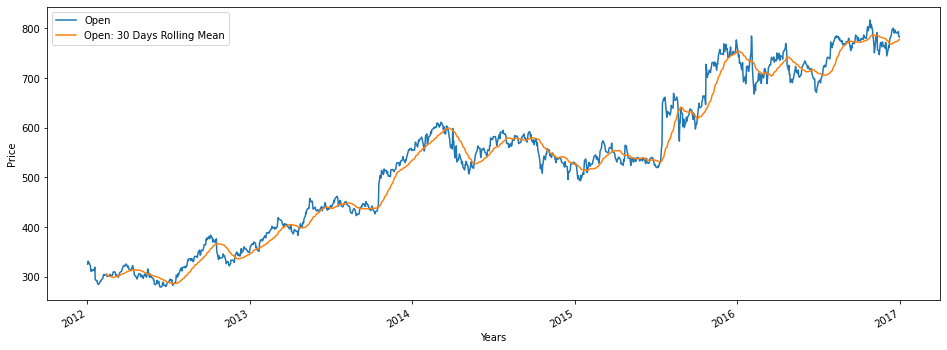

In [415]:
# Doing the 30 day rolling mean on the High column

data_train["Open: 30 Days Rolling Mean"] = data_train["Open"].rolling(window=30).mean()
data_train["Open"].plot(figsize=(16,6))
data_train["Open: 30 Days Rolling Mean"].plot() # plots the moving average of the past 30 days
plt.xlabel("Years")
plt.ylabel("Price")
plt.legend(loc="best")

In [416]:
# I assign column "Open" to variable "Data"

data = data_train["Open"].values # Open Column 
#print(data)
data = pd.DataFrame(data)
#data

In [417]:
# Scaling the values
sc = MinMaxScaler(feature_range =(0,1))
data_scaled = sc.fit_transform(data)
data_scaled.shape[0]

1258

Preprocessing Training Data
Creating a Data structure of 60 timestamps and 1 output

In [418]:
x_train = []
y_train =[]
timesteps = 60

# We add first 60 location to "X_train" and the 61 location to "y_train" .

for i in range(timesteps,data_scaled.shape[0]): # range syntax range(timesteps, train_data_scaled.shape[0])
    x_train.append(data_scaled[i-timesteps:i,0]) #  x_train.append(train_data_scaled[i-timesteps:i,0])
    y_train.append(data_scaled[i,0])                  # y_train.append(train_data_scaled[i,0])
x_train, y_train = np.array(x_train), np.array(y_train) 

#print(x_train)  
#reshaping 

x_train = np.reshape(x_train,(x_train.shape[0], x_train.shape[1],1))  # Dimension of array is 3.


In [419]:
#print(x_train)

# Training the model Using LSTM

In [420]:
# Initializing the RNN
model_lstm = Sequential()

In [421]:
#Adding LSTM and dropout layers

'''
Now, it’s time to build the model. We will build the LSTM with 50 neurons and 4 hidden layers. 
Finally, we will assign 1 neuron in the output layer for predicting the normalized stock price. 
'''

#Creating first LSTM layer giving the amount of units and the dimensions and 20% Dropout
model_lstm.add(LSTM(units =50,return_sequences = True,input_shape = (x_train.shape[1],1)))
model_lstm.add(Dropout(0.2))

#adding 2nd layer LSTM layer and 20% Dropout
model_lstm.add(LSTM(units = 50, return_sequences = True))
model_lstm.add(Dropout(0.2))

#adding 3rd layer LSTM layer and 20% Dropout
model_lstm.add(LSTM(units =50,return_sequences = True))
model_lstm.add(Dropout(0.2))

#adding fourth layer LSTM layer and 20% Dropout
model_lstm.add(LSTM(units =50))
model_lstm.add(Dropout(0.2))

#adding an output layer 

model_lstm.add(Dense(units =1))

#compiling model

model_lstm.compile(optimizer = 'adam' ,loss = 'mean_squared_error')

# Ftting the RNN to the training set

model_lstm.fit(x_train,y_train,epochs = 100,batch_size =32)

Epoch 1/100
38/38 [==============================] - 19s 111ms/step - loss: 0.0357
Epoch 2/100
38/38 [==============================] - 4s 107ms/step - loss: 0.0061
Epoch 3/100
38/38 [==============================] - 4s 108ms/step - loss: 0.0059
Epoch 4/100
38/38 [==============================] - 4s 109ms/step - loss: 0.0057
Epoch 5/100
38/38 [==============================] - 4s 103ms/step - loss: 0.0053
Epoch 6/100
38/38 [==============================] - 4s 104ms/step - loss: 0.0059
Epoch 7/100
38/38 [==============================] - 4s 105ms/step - loss: 0.0049
Epoch 8/100
38/38 [==============================] - 4s 109ms/step - loss: 0.0055
Epoch 9/100
38/38 [==============================] - 4s 102ms/step - loss: 0.0048
Epoch 10/100
38/38 [==============================] - 4s 105ms/step - loss: 0.0039
Epoch 11/100
38/38 [==============================] - 4s 107ms/step - loss: 0.0039
Epoch 12/100
38/38 [==============================] - 4s 107ms/step - loss: 0.0042
Epoch 13/100

Preprocessing Testing Data

In [422]:
data_test_stock = data_test["Open"]
#data_test_stock

In [423]:
dataset = pd.concat((data_train['Open'],data_test['Open']),axis =0)
inputs = dataset[len(dataset)-len(data_test)-timesteps:].values #Note the Syntax inputs = concat_data[len(concat_data) - len(test_data) - timesteps:]
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
#print (len(inputs))
x_test =[]
for i in range(timesteps,inputs.shape[0]): # range syntax range(timesteps, data_scaled.shape[0])
    x_test.append(inputs[i-timesteps:i,0])    # X_test.append(data_scaled[i-timesteps:i,0]) 
    
x_test = np.array(x_test)
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))   # Dimension of array is 3.

In [424]:
predict_price = model_lstm.predict(x_test)                 
predict_price_lstm = sc.inverse_transform(predict_price) # To get it out of the matrix form

Visualizing data LSTM Predictions

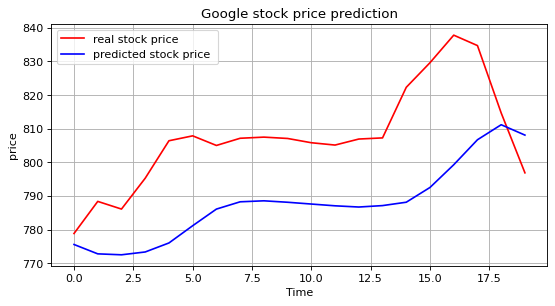

In [433]:
#visualizing data
plt.figure(figsize=(8,4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(data_test_stock,color='red',label = 'real stock price ')
plt.plot(predict_price_lstm,color='blue',label = 'predicted stock price ')
plt.grid(True)
plt.title('Google stock price prediction')
plt.xlabel('Time')
plt.ylabel('price')
plt.legend()
plt.show()

# Training the model Using RNN

In [426]:
# Initialising the RNN
model_rnn = Sequential()

# Adding the first RNN layer and some Dropout regularisation
model_rnn.add(SimpleRNN(units = 50,activation='tanh', return_sequences = True, input_shape = (x_train.shape[1], 1)))
model_rnn.add(Dropout(0.2)) 

# Adding a second RNN layer and some Dropout regularisation.
model_rnn.add(SimpleRNN(units = 50,activation='tanh', return_sequences = True))
model_rnn.add(Dropout(0.2))

# Adding a third RNN layer and some Dropout regularisation. 
model_rnn.add(SimpleRNN(units = 50,activation='tanh', return_sequences = True))
model_rnn.add(Dropout(0.2))

# Adding a fourth RNN layer and some Dropout regularisation.
model_rnn.add(SimpleRNN(units = 50))
model_rnn.add(Dropout(0.2))


# Adding the output layer
model_rnn.add(Dense(units = 1))

# Compiling the RNN
model_rnn.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
model_rnn.fit(x_train,y_train,epochs = 100,batch_size =32)

Epoch 1/100
38/38 [==============================] - 8s 44ms/step - loss: 0.3459
Epoch 2/100
38/38 [==============================] - 2s 43ms/step - loss: 0.2192
Epoch 3/100
38/38 [==============================] - 2s 42ms/step - loss: 0.1722
Epoch 4/100
38/38 [==============================] - 2s 42ms/step - loss: 0.1390
Epoch 5/100
38/38 [==============================] - 2s 42ms/step - loss: 0.1102
Epoch 6/100
38/38 [==============================] - 2s 46ms/step - loss: 0.0922
Epoch 7/100
38/38 [==============================] - 2s 47ms/step - loss: 0.0654
Epoch 8/100
38/38 [==============================] - 2s 46ms/step - loss: 0.0599
Epoch 9/100
38/38 [==============================] - 2s 44ms/step - loss: 0.0528
Epoch 10/100
38/38 [==============================] - 2s 45ms/step - loss: 0.0427
Epoch 11/100
38/38 [==============================] - 2s 45ms/step - loss: 0.0399
Epoch 12/100
38/38 [==============================] - 2s 42ms/step - loss: 0.0334
Epoch 13/100
38/38 [=====

In [427]:
data_test_stock = data_test["Open"]
dataset = pd.concat((data_train['Open'],data_test['Open']),axis =0)
inputs = dataset[len(dataset)-len(data_test)-timesteps:].values #Note the Syntax inputs = concat_data[len(concat_data) - len(test_data) - timesteps:]
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
#print (len(inputs))
x_test =[]
for i in range(timesteps,inputs.shape[0]): # range syntax range(timesteps, data_scaled.shape[0])
    x_test.append(inputs[i-timesteps:i,0])    # X_test.append(data_scaled[i-timesteps:i,0]) 
    
x_test = np.array(x_test)
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))   # Dimension of array is 3.
predict_price = model_rnn.predict(x_test)                 
predict_price_rnn = sc.inverse_transform(predict_price) # To get it out of the matrix form

Visualizing RNN Predictions

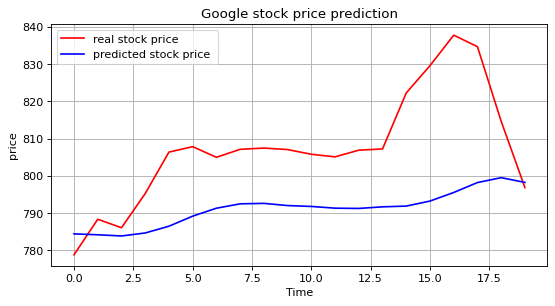

In [432]:
#visualizing data
plt.figure(figsize=(8,4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(data_test_stock,color='red',label = 'real stock price ')
plt.plot(predict_price_rnn,color='blue',label = 'predicted stock price ')
plt.grid(True)
plt.title('Google stock price prediction')
plt.xlabel('Time')
plt.ylabel('price')
plt.legend()
plt.show()

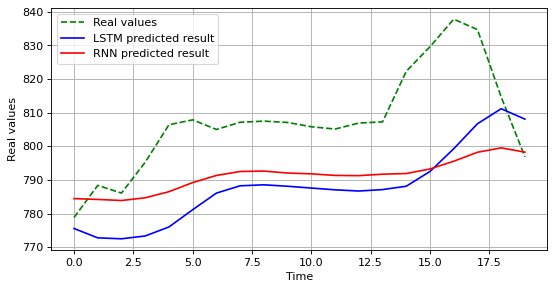

In [429]:
plt.figure(figsize=(8,4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(data_test_stock,color="green", linestyle='dashed',label="Real values")
plt.plot(predict_price_lstm,color="blue", label="LSTM predicted result")
plt.plot(predict_price_rnn,color="red",label="RNN predicted result") # ben ekledim
plt.legend()
plt.xlabel("Time")
plt.ylabel("Real values")
plt.grid(True)
plt.show()